In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import gzip
import _pickle as cPickle

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
        
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

## Data reading and preprocessing

In [5]:
# read data (reviews for model training and validation)
data_whole = pd.read_csv('./corpus/data_whole.csv',index_col = 0,na_filter=False)
len(data_whole)

100181

In [4]:
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords
import nltk
import string

stemmer = PorterStemmer()
stopset = stopwords.words('english') + ['will', 'also', 'said']
del_str = string.punctuation + string.digits
replace = str.maketrans(del_str,' '*len(del_str))

docs = []
for review_text in data_whole['review/text']: 
    sentences = nltk.sent_tokenize(review_text)
    review_doc = []
    for doc in sentences:
        doc = doc.encode("utf8").decode("utf8").encode('ascii', 'ignore').decode() # ignore fancy unicode chars  
        doc = doc.lower()
        doc = doc.replace("don't","do not").replace("dn't","d not").replace("sn't","s not").replace("ren't","re not").replace("won't","will not")
        doc = doc.translate(replace)
        doc = nltk.word_tokenize(doc)        
        # perform negation
        if "not" in doc:
            neg_idx = doc.index("not")
            pos_tags = nltk.pos_tag(doc)
            for idx in range(neg_idx+1,len(doc)):
                if pos_tags[idx][1] in ["JJ","JJR","JJS","RB","RBR","RBS","VB","VBG","VBN","VBP","VBZ"] or doc[idx]=="like":
                    doc[idx] = "neg_" + doc[idx]
        doc = [w for w in doc if w not in stopset]
        doc = [stemmer.stem(w) for w in doc]
        review_doc += doc
    docs.append(review_doc)

In [5]:
# build dictionary
import gensim
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=60, no_above=0.5)
dictionary.compactify()

c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\paramiko\transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend


In [6]:
len(dictionary) # number of unique tokens in dict

3025

In [36]:
# save dictionary for future use
dictionary.save("./corpus/negation_dict")

In [8]:
# pack into corpus
corpus = []
for doc in docs:
    packed_doc = [dictionary.token2id[word] for word in doc if word in dictionary.token2id.keys()]
    corpus.append(packed_doc)
    
data_whole['review_bow'] = corpus

In [38]:
data_whole.to_csv('./corpus/data_whole.csv')

## Model inference

In [10]:
from dataset import Dataset

# Jan and Feb 2010 as training set 
trainset = data_whole[data_whole['month'].isin([1,2])]
train_set = trainset[['review/profileName','beer/beerId','review/overall','review_bow']].copy()
train_set.columns = ['user','item','rating','review']
train_set = Dataset(corpus=train_set,vocab=dictionary)
# Mar 2010 as validation set
valset = data_whole[data_whole['month'].isin([3])]
val_set = valset[['review/profileName','beer/beerId','review/overall','review_bow']].copy()
val_set.columns = ['user','item','rating','review']

In [11]:
len(trainset),len(valset)

(66285, 33896)

In [12]:
# model construction
from Model_c import Model
model = Model(train_set, K=5, reg=0.01, alpha = 0.01)

In [13]:
# avg length of review
model.W_D/model.D 

33.217817002338386

In [45]:
# topic seed words
seed_words = []
appearance_w = [dictionary.token2id[word] for word in ['color', 'white','dark', 'brown','look','amber','glass','finger','orang','golden','floral']]
seed_words.append(appearance_w)
aroma_w = [dictionary.token2id[word] for word in ['smell', 'nose', 'citru', 'hint']]
seed_words.append(aroma_w)
palate_w = [dictionary.token2id[word] for word in ['carbon', 'bodi', 'mouthfeel', 'medium','palat', 'smooth','creami', 'feel', 'full', 'dri', 'mouth','thin','crisp', 'thick']]
seed_words.append(palate_w)
taste_w = [dictionary.token2id[word] for word in ['tast', 'flavor','aftertast', 'balanc']]
seed_words.append(taste_w)

In [46]:
# model initialization with topic seed words
# the topic seed words are only assigned with respective topics in initialization
for d, i, j, r, doc in model.trainset.all_reviews():
    for n in range(len(doc)):
        w = doc[n]
        for k in range(len(seed_words)):
            if w in seed_words[k]:
                model.gamma[d][n] = np.zeros(model.K*2)
                model.gamma[d][n][k] = 0.5
                model.gamma[d][n][k+model.K] = 0.5
                break

In [14]:
# define function for re-initialize with different normal distributions
def re_initialize(model,mu=0,sigma=0.1,seed=0):
    np.random.seed(seed)
    model.U = np.abs(np.random.normal(mu,sigma,size=(model.I,model.K)))     # user factor matrix
    model.V = np.random.normal(mu,sigma,size=(model.J,model.K))     # item factor matrix
    model.b_i = np.random.normal(mu,sigma,size=model.I)             # user bias vector
    model.b_j = np.random.normal(mu,sigma,size=model.J)             # item bias vector

### Inference of standard latent factor model

In [19]:
# model inference of latent factor model using ratings only
model.reg = 0.06 # regularization parameter
re_initialize(model,mu=0,sigma=0.01,seed=0)
model.RatingMF_SGD(lr_sgd = 0.005, test_set = val_set, threshold=0.0001)

Epoch 0, test MSE = 8.772720940277132
Epoch 1, test MSE = 8.146347076118925
Epoch 2, test MSE = 7.722494396330388
Epoch 3, test MSE = 7.410043748911569
Epoch 4, test MSE = 7.1675784981735395
Epoch 5, test MSE = 6.97288033937749
Epoch 6, test MSE = 6.812578514288986
Epoch 7, test MSE = 6.67798219860783
Epoch 8, test MSE = 6.563131457051299
Epoch 9, test MSE = 6.4637678695182474
Epoch 10, test MSE = 6.376745726856462
Epoch 11, test MSE = 6.299696631967746
Epoch 12, test MSE = 6.230806770469381
Epoch 13, test MSE = 6.1687203112535665
Epoch 14, test MSE = 6.112457685636446
Epoch 15, test MSE = 6.061267338082786
Epoch 16, test MSE = 6.014602776403905
Epoch 17, test MSE = 5.972102933013146
Epoch 18, test MSE = 5.933533066666943
Epoch 19, test MSE = 5.898694512985236
Epoch 20, test MSE = 5.867336431177215
Epoch 21, test MSE = 5.839179139162204
Epoch 22, test MSE = 5.8139735186789645
Epoch 23, test MSE = 5.791517080217391
Epoch 24, test MSE = 5.771651002102766
Epoch 25, test MSE = 5.7542413254

In [20]:
# save model for future use
save_zipped_pickle(model, './models/RatingMF_reg' + str(model.reg) + '.p')

### Inference of United latent factor model

In [48]:
# model inference of latent factor model using both ratings and reviews
model.reg=0.01
model.alpha = 0.01
re_initialize(model,mu=0,sigma=0.01,seed=0)
model.UnitedMF_SGD(lr_sgd = 0.005, test_set = val_set, threshold=0.0001, update_kappa=True)

Epoch 0, test MSE = 8.765308382545589
Epoch 1, test MSE = 8.129725400265187
Epoch 2, test MSE = 7.699392689510695
Epoch 3, test MSE = 7.381569211838095
Epoch 4, test MSE = 7.134202411318783
Epoch 5, test MSE = 6.9349198963846765
Epoch 6, test MSE = 6.7703150622845625
Epoch 7, test MSE = 6.631659132772679
Epoch 8, test MSE = 6.512927108782794
Epoch 9, test MSE = 6.40976572872157
Epoch 10, test MSE = 6.31891200513507
Epoch 11, test MSE = 6.237885970542073
Epoch 12, test MSE = 6.164803380295824
Epoch 13, test MSE = 6.098420682773966
Epoch 14, test MSE = 6.03804269162232
Epoch 15, test MSE = 5.983383131082658
Epoch 16, test MSE = 5.93425339089631
Epoch 17, test MSE = 5.890234225978135
Epoch 18, test MSE = 5.850730236715048
Epoch 19, test MSE = 5.8152229403618945
Epoch 20, test MSE = 5.783370768849482
Epoch 21, test MSE = 5.754944226395279
Epoch 22, test MSE = 5.729759750258205
Epoch 23, test MSE = 5.707635820023223
Epoch 24, test MSE = 5.688366090635322
Epoch 25, test MSE = 5.6717509568742

In [49]:
model.kappa

2.2803894895110526

In [50]:
# save model for future use
save_zipped_pickle(model, './models/UnitedMF_reg' + str(model.reg) + '_alpha' + str(model.alpha) + '.p')

In [51]:
# prediction errors
rating_loss = 0
errors = []
for index, row in val_set.iterrows():
    j = row['item']
    r = row['rating']
    i = row['user']
    r_hat = model.predict_rating(i,j)
    rating_loss += (r_hat-r)**2
    errors.append(r - r_hat)
print(rating_loss/len(val_set)) # MSE on validation set

5.6107113562868625


-0.5914608965313294


(array([1.9000e+01, 5.2000e+01, 9.2000e+01, 2.0500e+02, 4.7700e+02,
        1.1430e+03, 3.2510e+03, 9.8060e+03, 1.2666e+04, 4.9810e+03,
        9.9000e+02, 1.8200e+02, 1.7000e+01, 1.2000e+01, 3.0000e+00]),
 array([-15.20665567, -13.38471314, -11.56277061,  -9.74082808,
         -7.91888555,  -6.09694303,  -4.2750005 ,  -2.45305797,
         -0.63111544,   1.19082709,   3.01276961,   4.83471214,
          6.65665467,   8.4785972 ,  10.30053973,  12.12248225]),
 <BarContainer object of 15 artists>)

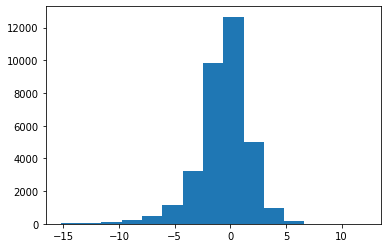

In [52]:
# distribution of prediction errors
print(np.mean(errors))
plt.hist(errors,bins=15)

## Qualitative analysis of derived topics

In [4]:
from gensim.corpora import Dictionary
# load existing model and dictionary
model = load_zipped_pickle('./models/UnitedMF_reg0.01_alpha0.01.p')
dictionary = Dictionary.load('./corpus/negation_dict')

In [57]:
import numpy as np
# produce top topic words in positive side
for k in range(model.K):
    pos = np.argsort(model.phi[k])[::-1]    
    sorted_counts = model.phi[k][pos][:15]
    sorted_vocab = [dictionary[idx] for idx in pos[:15]]
    output = ''
    for word, weight in zip(sorted_vocab, sorted_counts):
        #output += '%s (%.3f), ' % (word, weight)
        output += '%s, ' % word
    print(k, output)

0 dark, brown, white, orang, amber, color, floral, pour, malt, nice, hop, sweet, golden, chocol, bitter, 
1 citru, nose, sweet, pour, malt, roast, finish, bottl, nice, chocol, bitter, hint, caramel, light, hop, 
2 bodi, medium, dri, carbon, smooth, creami, full, palat, hop, mouthfeel, thick, nice, pour, thin, malt, 
3 flavor, tast, balanc, malt, sweet, nice, hop, pour, beer, caramel, bitter, light, good, finish, bottl, 
4 malt, sweet, hop, nice, pour, caramel, finish, chocol, bottl, note, bitter, fruit, beer, roast, coffe, 


In [59]:
# produce top topic words in negative side
for k in range(model.K):
    pos = np.argsort(model.phi[k+model.K])[::-1]    
    sorted_counts = model.phi[k+model.K][pos][:15]
    sorted_vocab = [dictionary[idx] for idx in pos[:15]]
    output = ''
    for word, weight in zip(sorted_vocab, sorted_counts):
        #output += '%s (%.3f), ' % (word, weight)
        output += '%s, ' % word
    print(k, output)

0 white, color, golden, amber, dark, brown, orang, pour, malt, light, sweet, beer, hop, bottl, floral, 
1 light, nose, hint, citru, sweet, bottl, clear, pour, beer, hop, malt, smell, finish, yellow, bitter, 
2 bodi, medium, carbon, thin, dri, palat, beer, malt, sweet, mouthfeel, light, hop, pour, creami, bottl, 
3 flavor, tast, light, sweet, beer, bottl, malt, hop, pour, balanc, finish, bitter, aftertast, malti, note, 
4 beer, malt, sweet, light, hop, bottl, pour, finish, note, bitter, like, bit, caramel, littl, clear, 
